In [ ]:
import numpy as np
import os
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score

# Phase 1: Data analysis & preparation

In [ ]:
# Load Data
if os.path.exists('online_shoppers_intention.csv'):
    os.remove('online_shoppers_intention.csv')

uploaded = files.upload()

df = pd.read_csv('online_shoppers_intention.csv')

Saving online_shoppers_intention.csv to online_shoppers_intention.csv


In [ ]:
pd.set_option('display.max_columns', None)
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


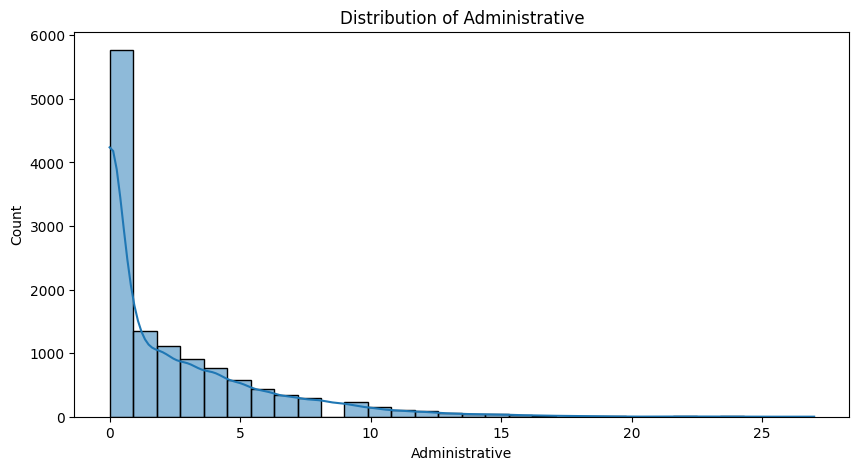

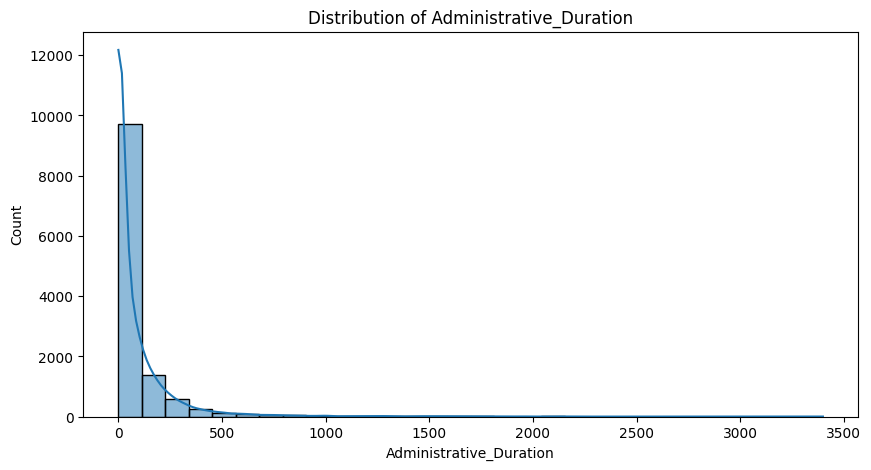

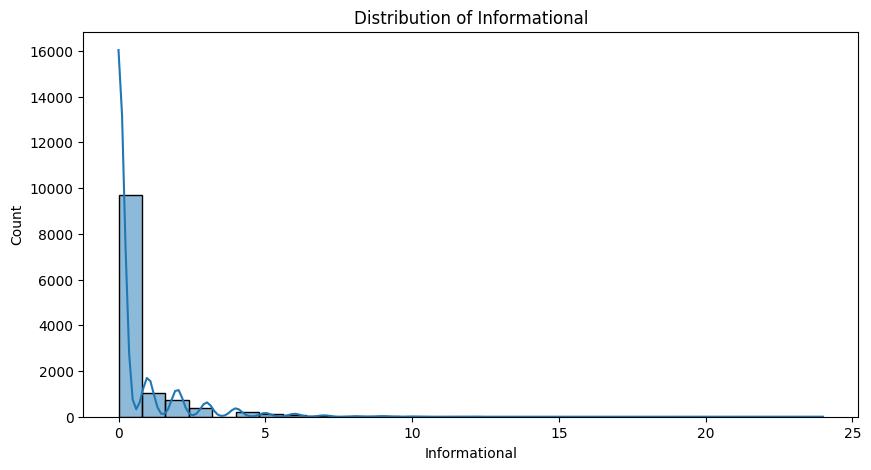

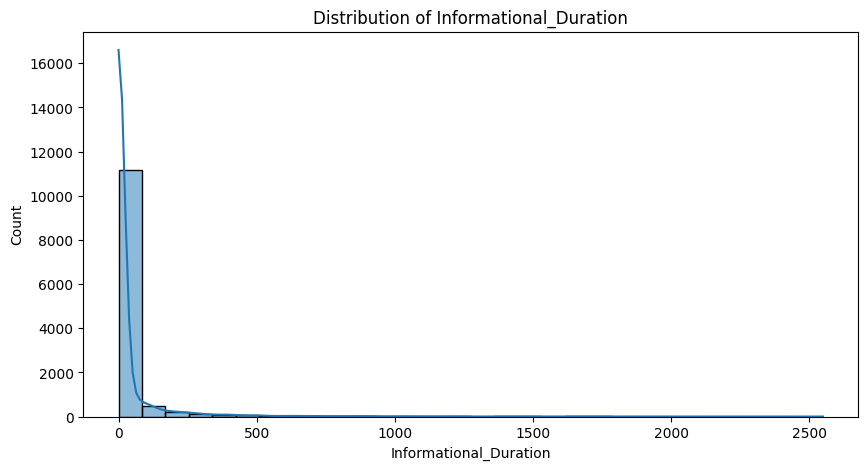

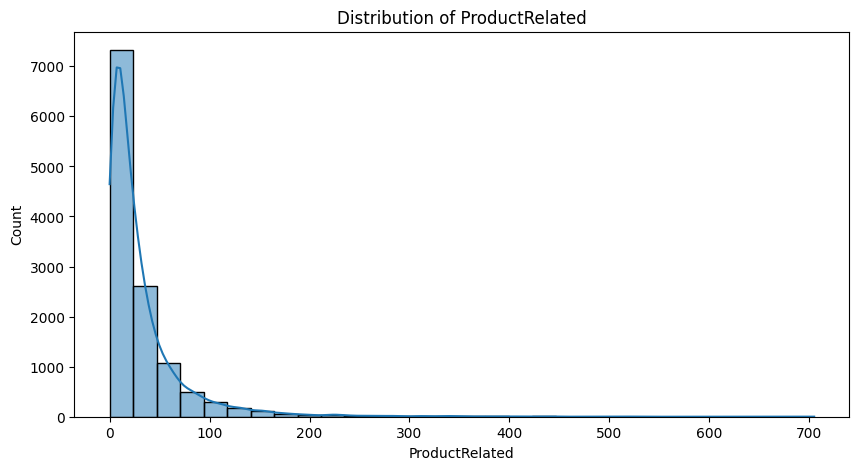

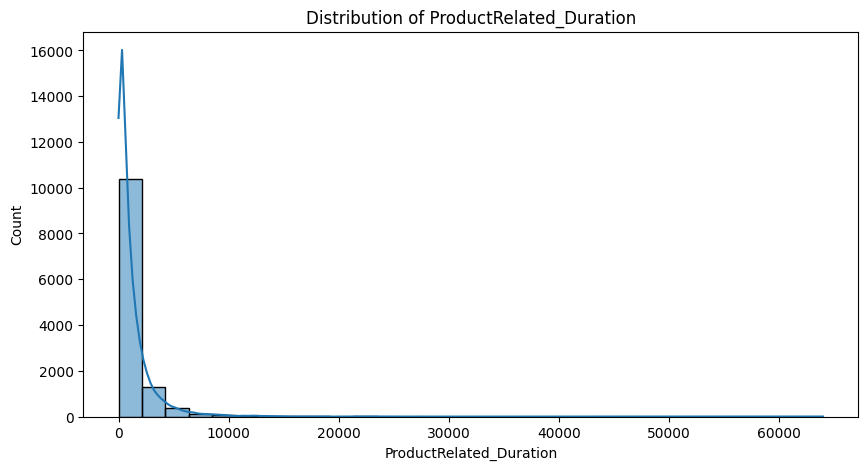

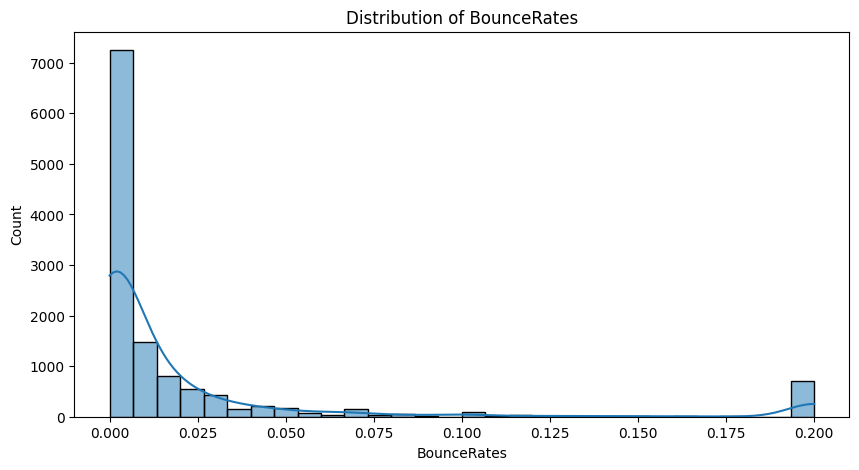

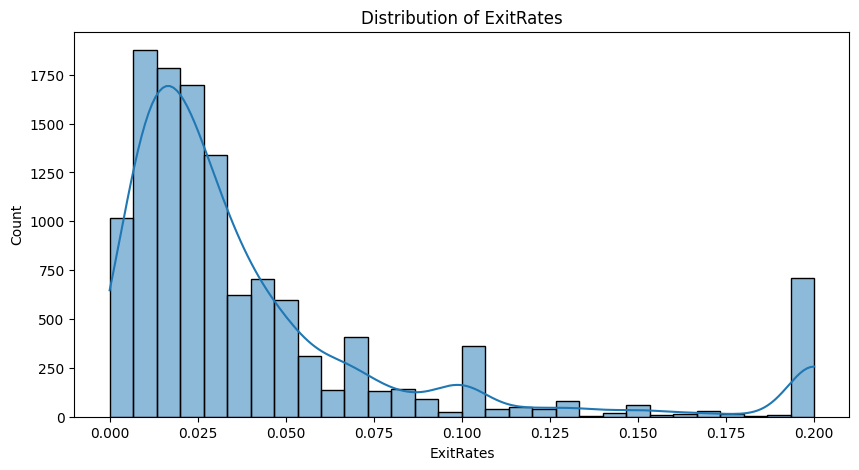

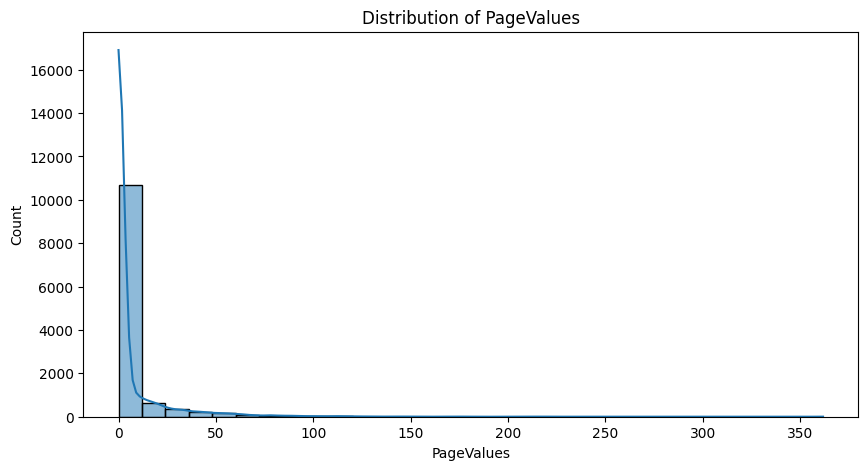

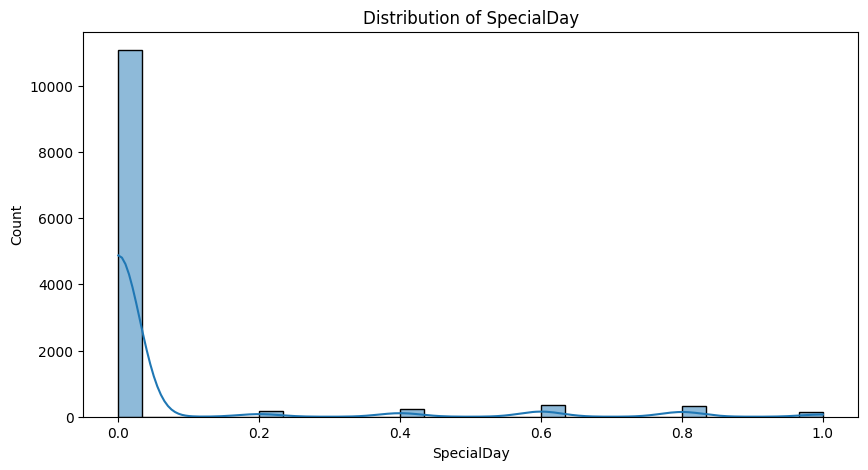

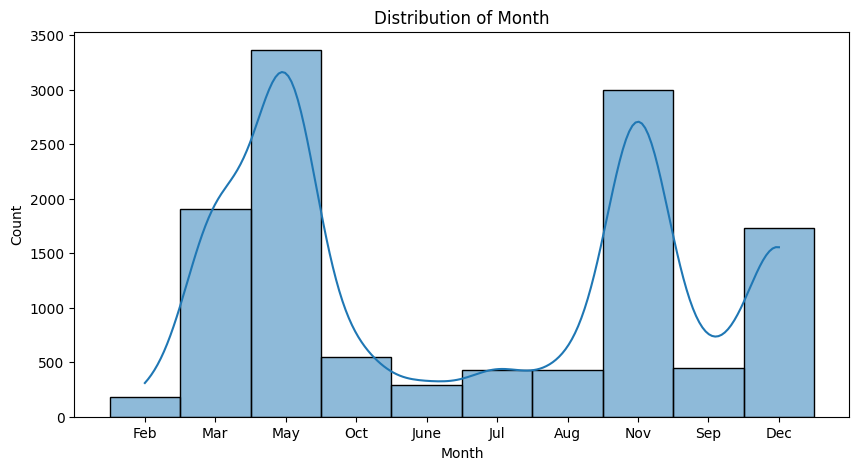

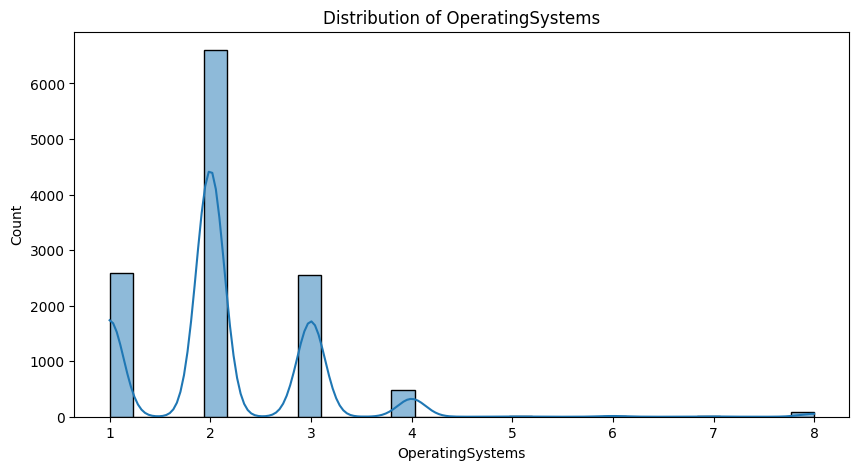

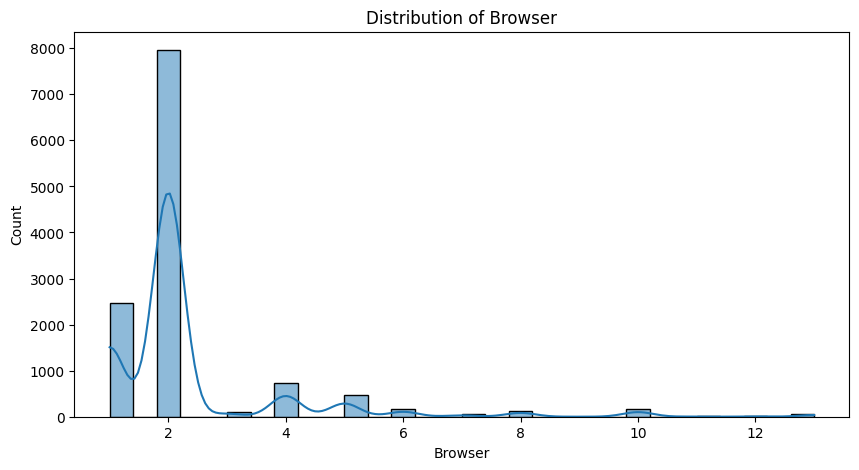

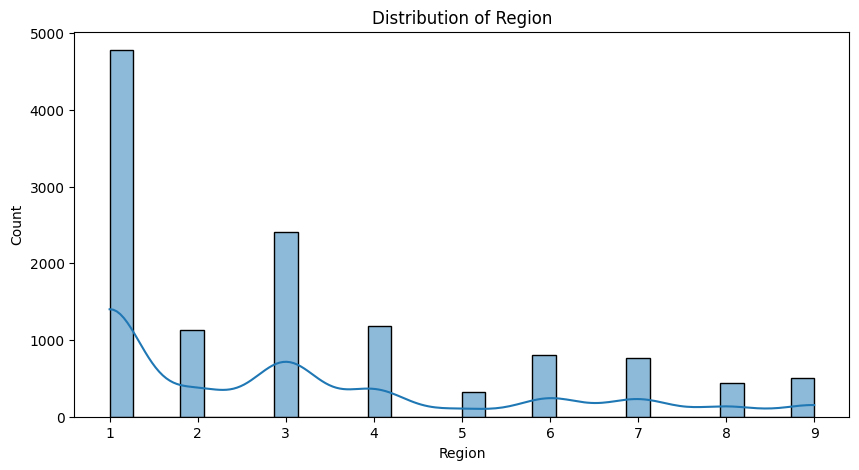

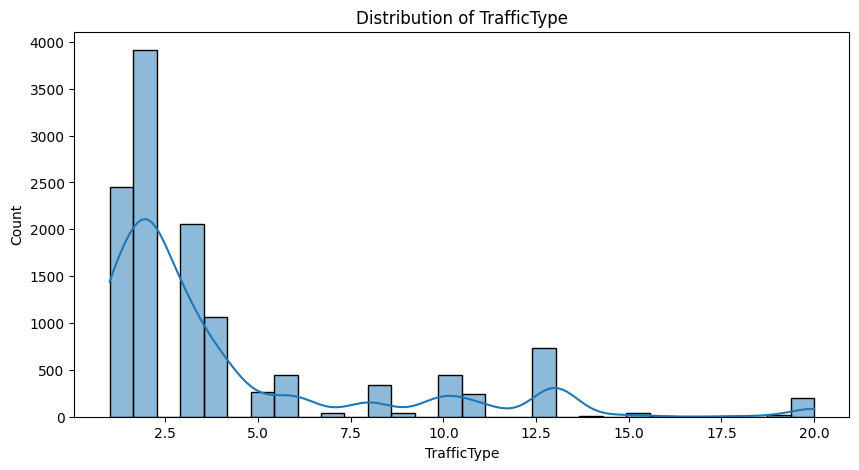

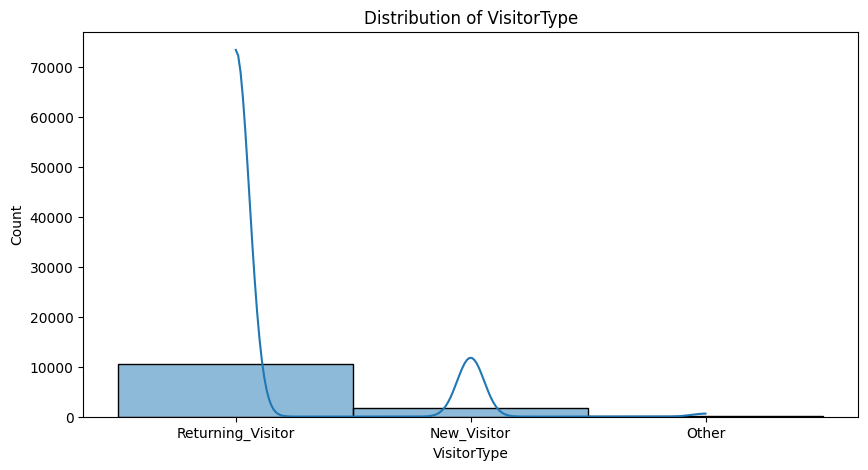

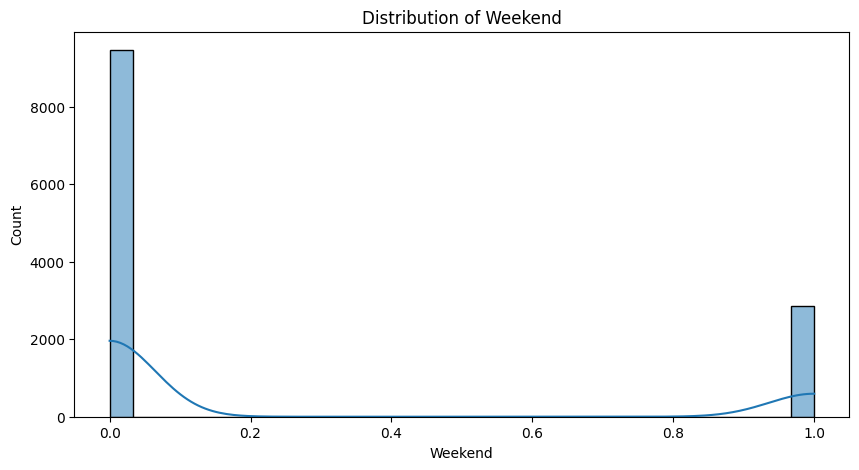

In [ ]:
# Plot distributions of each input feature
for column in df.columns:
    if column != 'Revenue':
        plt.figure(figsize=(10, 5))
        sns.histplot(df[column], bins=30, kde=True)
        plt.title(f'Distribution of {column}')
        plt.show()

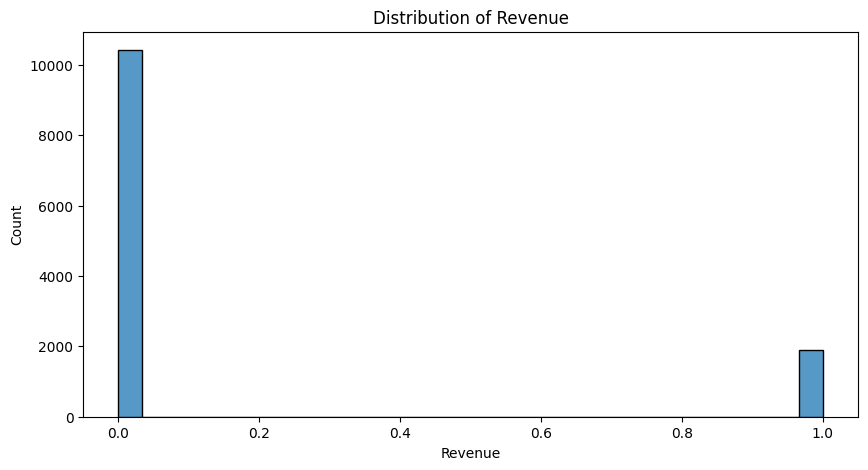

In [ ]:
# Plot distribution of output label
plt.figure(figsize=(10, 5))
sns.histplot(df['Revenue'], bins=30, kde=False)
plt.title('Distribution of Revenue')
plt.show()

In [ ]:
# Calcualte data balance
class_counts = df['Revenue'].value_counts()
class_percentages = class_counts / len(df) * 100
print(class_percentages)

Revenue
False    84.525547
True     15.474453
Name: count, dtype: float64


In [ ]:
# Range of values (min, max, mean, median, etc.)
print(df.describe())

       Administrative  Administrative_Duration  Informational  \
count    12330.000000             12330.000000   12330.000000   
mean         2.315166                80.818611       0.503569   
std          3.321784               176.779107       1.270156   
min          0.000000                 0.000000       0.000000   
25%          0.000000                 0.000000       0.000000   
50%          1.000000                 7.500000       0.000000   
75%          4.000000                93.256250       0.000000   
max         27.000000              3398.750000      24.000000   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
count            12330.000000    12330.000000             12330.000000   
mean                34.472398       31.731468              1194.746220   
std                140.749294       44.475503              1913.669288   
min                  0.000000        0.000000                 0.000000   
25%                  0.000000        7.00000

In [ ]:
# Display missing values
missing_values = df.isnull().sum()

print(missing_values)

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


In [ ]:
# Normalize numerical data
numerical_cols = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
                  'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues',
                  'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']

for col in numerical_cols:
    col_min = df[col].min()
    col_max = df[col].max()
    df[col] = (df[col] - col_min) / (col_max - col_min)

In [ ]:
# Normalize categorical data
columns_to_encode = ['Month', 'VisitorType']

for column in columns_to_encode:
    unique_values = df[column].unique()

    for value in unique_values:
        df[column + '_' + str(value)] = df[column].apply(lambda x: 1 if x == value else 0)

    df = df.drop(column, axis=1)

In [ ]:
# Normalize boolean data
columns_to_convert = ['Weekend', 'Revenue']

for column in columns_to_convert:
    df[column] = df[column].apply(lambda x: 1 if x else 0)

In [ ]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue,Month_Feb,Month_Mar,Month_May,Month_Oct,Month_June,Month_Jul,Month_Aug,Month_Nov,Month_Sep,Month_Dec,VisitorType_Returning_Visitor,VisitorType_New_Visitor,VisitorType_Other
0,0.0,0.0,0.0,0.0,0.001418,0.000000,1.00,1.00,0.0,0.0,0.000000,0.000000,0.000,0.000000,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.0,0.0,0.0,0.0,0.002837,0.001000,0.00,0.50,0.0,0.0,0.142857,0.083333,0.000,0.052632,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,0.0,0.0,0.0,0.0,0.001418,0.000000,1.00,1.00,0.0,0.0,0.428571,0.000000,1.000,0.105263,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,0.0,0.0,0.0,0.0,0.002837,0.000042,0.25,0.70,0.0,0.0,0.285714,0.083333,0.125,0.157895,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.0,0.0,0.0,0.0,0.014184,0.009809,0.10,0.25,0.0,0.0,0.285714,0.166667,0.000,0.157895,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0


# Phase 2: Build a model to overfit the entire dataset

In [ ]:
# Define the model
model = Sequential()
model.add(Dense(1, input_dim=df.shape[1]-1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
history = model.fit(df.drop('Revenue', axis=1), df['Revenue'], epochs=300, verbose=1)

Epoch 1/300
386/386 [==============================] - 1s 2ms/step - loss: 0.5587 - accuracy: 0.7671
Epoch 2/300
386/386 [==============================] - 1s 2ms/step - loss: 0.4273 - accuracy: 0.8453
Epoch 3/300
386/386 [==============================] - 1s 2ms/step - loss: 0.4037 - accuracy: 0.8453
Epoch 4/300
386/386 [==============================] - 1s 2ms/step - loss: 0.3934 - accuracy: 0.8454
Epoch 5/300
386/386 [==============================] - 1s 2ms/step - loss: 0.3860 - accuracy: 0.8455
Epoch 6/300
386/386 [==============================] - 1s 2ms/step - loss: 0.3802 - accuracy: 0.8457
Epoch 7/300
386/386 [==============================] - 1s 2ms/step - loss: 0.3755 - accuracy: 0.8460
Epoch 8/300
386/386 [==============================] - 1s 2ms/step - loss: 0.3713 - accuracy: 0.8465
Epoch 9/300
386/386 [==============================] - 1s 2ms/step - loss: 0.3676 - accuracy: 0.8467
Epoch 10/300
386/386 [==============================] - 1s 2ms/step - loss: 0.3643 - accura

In [ ]:
# Define the model
model = Sequential()
model.add(Dense(2, input_dim=df.shape[1]-1, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
history = model.fit(df.drop('Revenue', axis=1), df['Revenue'], epochs=300, verbose=1)

Epoch 1/300
386/386 [==============================] - 1s 2ms/step - loss: 0.4700 - accuracy: 0.8453
Epoch 2/300
386/386 [==============================] - 1s 2ms/step - loss: 0.3967 - accuracy: 0.8453
Epoch 3/300
386/386 [==============================] - 1s 2ms/step - loss: 0.3776 - accuracy: 0.8453
Epoch 4/300
386/386 [==============================] - 1s 2ms/step - loss: 0.3657 - accuracy: 0.8453
Epoch 5/300
386/386 [==============================] - 1s 2ms/step - loss: 0.3568 - accuracy: 0.8453
Epoch 6/300
386/386 [==============================] - 1s 2ms/step - loss: 0.3495 - accuracy: 0.8453
Epoch 7/300
386/386 [==============================] - 1s 3ms/step - loss: 0.3429 - accuracy: 0.8453
Epoch 8/300
386/386 [==============================] - 1s 3ms/step - loss: 0.3364 - accuracy: 0.8507
Epoch 9/300
386/386 [==============================] - 1s 2ms/step - loss: 0.3304 - accuracy: 0.8579
Epoch 10/300
386/386 [==============================] - 1s 2ms/step - loss: 0.3246 - accura

In [ ]:
# Define the model
model = Sequential()
model.add(Dense(10, input_dim=df.shape[1]-1, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
history = model.fit(df.drop('Revenue', axis=1), df['Revenue'], epochs=300, verbose=1)

Epoch 1/300
386/386 [==============================] - 1s 2ms/step - loss: 0.4218 - accuracy: 0.8427
Epoch 2/300
386/386 [==============================] - 1s 2ms/step - loss: 0.3666 - accuracy: 0.8463
Epoch 3/300
386/386 [==============================] - 1s 2ms/step - loss: 0.3397 - accuracy: 0.8564
Epoch 4/300
386/386 [==============================] - 1s 2ms/step - loss: 0.3089 - accuracy: 0.8718
Epoch 5/300
386/386 [==============================] - 1s 2ms/step - loss: 0.2890 - accuracy: 0.8825
Epoch 6/300
386/386 [==============================] - 1s 3ms/step - loss: 0.2786 - accuracy: 0.8875
Epoch 7/300
386/386 [==============================] - 1s 3ms/step - loss: 0.2729 - accuracy: 0.8895
Epoch 8/300
386/386 [==============================] - 1s 3ms/step - loss: 0.2679 - accuracy: 0.8905
Epoch 9/300
386/386 [==============================] - 1s 3ms/step - loss: 0.2649 - accuracy: 0.8926
Epoch 10/300
386/386 [==============================] - 1s 3ms/step - loss: 0.2617 - accura

In [ ]:
# Define the model
model = Sequential()
model.add(Dense(50, input_dim=df.shape[1]-1, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
history = model.fit(df.drop('Revenue', axis=1), df['Revenue'], epochs=300, verbose=1)

Epoch 1/300
386/386 [==============================] - 2s 2ms/step - loss: 0.3764 - accuracy: 0.8483
Epoch 2/300
386/386 [==============================] - 1s 2ms/step - loss: 0.2960 - accuracy: 0.8823
Epoch 3/300
386/386 [==============================] - 1s 2ms/step - loss: 0.2678 - accuracy: 0.8919
Epoch 4/300
386/386 [==============================] - 1s 2ms/step - loss: 0.2540 - accuracy: 0.8953
Epoch 5/300
386/386 [==============================] - 1s 2ms/step - loss: 0.2474 - accuracy: 0.8990
Epoch 6/300
386/386 [==============================] - 1s 2ms/step - loss: 0.2419 - accuracy: 0.8991
Epoch 7/300
386/386 [==============================] - 1s 2ms/step - loss: 0.2356 - accuracy: 0.8995
Epoch 8/300
386/386 [==============================] - 1s 2ms/step - loss: 0.2373 - accuracy: 0.9009
Epoch 9/300
386/386 [==============================] - 1s 2ms/step - loss: 0.2311 - accuracy: 0.9033
Epoch 10/300
386/386 [==============================] - 1s 2ms/step - loss: 0.2287 - accura

# Phase 3: Model selection & evaluation

In [ ]:
# Shuffle rows
df = df.sample(frac=1, random_state=42)

In [ ]:
# Split data
train_size = int(0.8 * len(df))

train_df = df[:train_size]
val_df = df[train_size:]

X_train = train_df.drop('Revenue', axis=1)
y_train = train_df['Revenue']

X_val = val_df.drop('Revenue', axis=1)
y_val = val_df['Revenue']

In [ ]:
# Define the models
models = {
    'Logistic regression model': Sequential([Dense(1, input_dim=X_train.shape[1], activation='sigmoid')]),
    'Neural network model (64-32-16-8-1)': Sequential([Dense(64, input_dim=X_train.shape[1], activation='relu'),
                                                       Dense(32, activation='relu'),
                                                       Dense(16, activation='relu'),
                                                       Dense(8, activation='relu'),
                                                       Dense(1, activation='sigmoid')]),
    'Neural network model (32-16-8-1)': Sequential([Dense(32, input_dim=X_train.shape[1], activation='relu'),
                                                    Dense(16, activation='relu'),
                                                    Dense(8, activation='relu'),
                                                    Dense(1, activation='sigmoid')]),
    'Neural network model (16-8-1)': Sequential([Dense(16, input_dim=X_train.shape[1], activation='relu'),
                                                 Dense(8, activation='relu'),
                                                 Dense(1, activation='sigmoid')]),
    'Neural network model (8-1)': Sequential([Dense(8, input_dim=X_train.shape[1], activation='relu'),
                                              Dense(1, activation='sigmoid')]),
    'Neural network model (4-1)': Sequential([Dense(4, input_dim=X_train.shape[1], activation='relu'),
                                              Dense(1, activation='sigmoid')]),
    'Neural network model (2-1)': Sequential([Dense(2, input_dim=X_train.shape[1], activation='relu'),
                                              Dense(1, activation='sigmoid')])
}

In [ ]:
# Train models
os.makedirs('checkpoints', exist_ok=True)

for name, model in models.items():
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(filepath=f'checkpoints/{name}.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[checkpoint], verbose=0)

    model.load_weights(f'checkpoints/{name}.h5')

    y_val_pred = model.predict(X_val)
    y_val_pred = (y_val_pred > 0.5).astype(int)

    print(f'\n{name}')

    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    print('\nTraining Accuracy: %.3f' % (train_acc))

    _, val_acc = model.evaluate(X_val, y_val, verbose=0)
    print('Validation Accuracy: %.3f' % (val_acc))

    print(classification_report(y_val, y_val_pred))


Epoch 1: val_loss improved from inf to 0.46898, saving model to checkpoints/Logistic regression model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.46898 to 0.42405, saving model to checkpoints/Logistic regression model.h5

Epoch 3: val_loss improved from 0.42405 to 0.40814, saving model to checkpoints/Logistic regression model.h5

Epoch 4: val_loss improved from 0.40814 to 0.39868, saving model to checkpoints/Logistic regression model.h5

Epoch 5: val_loss improved from 0.39868 to 0.39175, saving model to checkpoints/Logistic regression model.h5

Epoch 6: val_loss improved from 0.39175 to 0.38643, saving model to checkpoints/Logistic regression model.h5

Epoch 7: val_loss improved from 0.38643 to 0.38216, saving model to checkpoints/Logistic regression model.h5

Epoch 8: val_loss improved from 0.38216 to 0.37851, saving model to checkpoints/Logistic regression model.h5

Epoch 9: val_loss improved from 0.37851 to 0.37530, saving model to checkpoints/Logistic regression model.h5

Epoch 10: val_loss improved from 0.37530 to 0.37238, saving model to checkpoints/Logistic regression model.h5

Epoch 11

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.35528 to 0.29924, saving model to checkpoints/Neural network model (64-32-16-8-1).h5

Epoch 3: val_loss improved from 0.29924 to 0.27284, saving model to checkpoints/Neural network model (64-32-16-8-1).h5

Epoch 4: val_loss improved from 0.27284 to 0.26596, saving model to checkpoints/Neural network model (64-32-16-8-1).h5

Epoch 5: val_loss improved from 0.26596 to 0.25524, saving model to checkpoints/Neural network model (64-32-16-8-1).h5

Epoch 6: val_loss did not improve from 0.25524

Epoch 7: val_loss improved from 0.25524 to 0.24271, saving model to checkpoints/Neural network model (64-32-16-8-1).h5

Epoch 8: val_loss did not improve from 0.24271

Epoch 9: val_loss did not improve from 0.24271

Epoch 10: val_loss did not improve from 0.24271

Epoch 11: val_loss did not improve from 0.24271

Epoch 12: val_loss improved from 0.24271 to 0.23781, saving model to checkpoints/Neural network model (64-32-16-8-1).h5

Epoch 13: val_loss did not improve f

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.37203 to 0.33533, saving model to checkpoints/Neural network model (32-16-8-1).h5

Epoch 3: val_loss improved from 0.33533 to 0.29912, saving model to checkpoints/Neural network model (32-16-8-1).h5

Epoch 4: val_loss improved from 0.29912 to 0.28181, saving model to checkpoints/Neural network model (32-16-8-1).h5

Epoch 5: val_loss improved from 0.28181 to 0.26037, saving model to checkpoints/Neural network model (32-16-8-1).h5

Epoch 6: val_loss improved from 0.26037 to 0.25672, saving model to checkpoints/Neural network model (32-16-8-1).h5

Epoch 7: val_loss did not improve from 0.25672

Epoch 8: val_loss improved from 0.25672 to 0.25340, saving model to checkpoints/Neural network model (32-16-8-1).h5

Epoch 9: val_loss improved from 0.25340 to 0.25050, saving model to checkpoints/Neural network model (32-16-8-1).h5

Epoch 10: val_loss did not improve from 0.25050

Epoch 11: val_loss improved from 0.25050 to 0.24897, saving model to checkpoints/Ne

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.38413 to 0.36172, saving model to checkpoints/Neural network model (16-8-1).h5

Epoch 3: val_loss improved from 0.36172 to 0.33606, saving model to checkpoints/Neural network model (16-8-1).h5

Epoch 4: val_loss improved from 0.33606 to 0.31109, saving model to checkpoints/Neural network model (16-8-1).h5

Epoch 5: val_loss improved from 0.31109 to 0.29456, saving model to checkpoints/Neural network model (16-8-1).h5

Epoch 6: val_loss improved from 0.29456 to 0.28579, saving model to checkpoints/Neural network model (16-8-1).h5

Epoch 7: val_loss improved from 0.28579 to 0.28222, saving model to checkpoints/Neural network model (16-8-1).h5

Epoch 8: val_loss improved from 0.28222 to 0.27387, saving model to checkpoints/Neural network model (16-8-1).h5

Epoch 9: val_loss improved from 0.27387 to 0.27278, saving model to checkpoints/Neural network model (16-8-1).h5

Epoch 10: val_loss improved from 0.27278 to 0.26975, saving model to checkpoints/Neural

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.41212 to 0.37737, saving model to checkpoints/Neural network model (8-1).h5

Epoch 3: val_loss improved from 0.37737 to 0.35742, saving model to checkpoints/Neural network model (8-1).h5

Epoch 4: val_loss improved from 0.35742 to 0.34204, saving model to checkpoints/Neural network model (8-1).h5

Epoch 5: val_loss improved from 0.34204 to 0.33154, saving model to checkpoints/Neural network model (8-1).h5

Epoch 6: val_loss improved from 0.33154 to 0.32164, saving model to checkpoints/Neural network model (8-1).h5

Epoch 7: val_loss improved from 0.32164 to 0.31405, saving model to checkpoints/Neural network model (8-1).h5

Epoch 8: val_loss improved from 0.31405 to 0.30824, saving model to checkpoints/Neural network model (8-1).h5

Epoch 9: val_loss improved from 0.30824 to 0.30231, saving model to checkpoints/Neural network model (8-1).h5

Epoch 10: val_loss improved from 0.30231 to 0.29869, saving model to checkpoints/Neural network model (8-1).h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.46641 to 0.40545, saving model to checkpoints/Neural network model (4-1).h5

Epoch 3: val_loss improved from 0.40545 to 0.38997, saving model to checkpoints/Neural network model (4-1).h5

Epoch 4: val_loss improved from 0.38997 to 0.37737, saving model to checkpoints/Neural network model (4-1).h5

Epoch 5: val_loss improved from 0.37737 to 0.36637, saving model to checkpoints/Neural network model (4-1).h5

Epoch 6: val_loss improved from 0.36637 to 0.35778, saving model to checkpoints/Neural network model (4-1).h5

Epoch 7: val_loss improved from 0.35778 to 0.35034, saving model to checkpoints/Neural network model (4-1).h5

Epoch 8: val_loss improved from 0.35034 to 0.34369, saving model to checkpoints/Neural network model (4-1).h5

Epoch 9: val_loss improved from 0.34369 to 0.33813, saving model to checkpoints/Neural network model (4-1).h5

Epoch 10: val_loss improved from 0.33813 to 0.33240, saving model to checkpoints/Neural network model (4-1).h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.42913 to 0.39749, saving model to checkpoints/Neural network model (2-1).h5

Epoch 3: val_loss improved from 0.39749 to 0.37921, saving model to checkpoints/Neural network model (2-1).h5

Epoch 4: val_loss improved from 0.37921 to 0.36742, saving model to checkpoints/Neural network model (2-1).h5

Epoch 5: val_loss improved from 0.36742 to 0.35852, saving model to checkpoints/Neural network model (2-1).h5

Epoch 6: val_loss improved from 0.35852 to 0.35098, saving model to checkpoints/Neural network model (2-1).h5

Epoch 7: val_loss improved from 0.35098 to 0.34421, saving model to checkpoints/Neural network model (2-1).h5

Epoch 8: val_loss improved from 0.34421 to 0.33926, saving model to checkpoints/Neural network model (2-1).h5

Epoch 9: val_loss improved from 0.33926 to 0.33297, saving model to checkpoints/Neural network model (2-1).h5

Epoch 10: val_loss improved from 0.33297 to 0.32775, saving model to checkpoints/Neural network model (2-1).h5



Epoch 1: val_loss improved from inf to 0.22960, saving model to checkpoints/Neural network model (8-1).h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 0.22960

Epoch 3: val_loss did not improve from 0.22960

Epoch 4: val_loss did not improve from 0.22960

Epoch 5: val_loss improved from 0.22960 to 0.22931, saving model to checkpoints/Neural network model (8-1).h5

Epoch 6: val_loss improved from 0.22931 to 0.22896, saving model to checkpoints/Neural network model (8-1).h5

Epoch 7: val_loss did not improve from 0.22896

Epoch 8: val_loss did not improve from 0.22896

Epoch 9: val_loss improved from 0.22896 to 0.22851, saving model to checkpoints/Neural network model (8-1).h5

Epoch 10: val_loss did not improve from 0.22851

Epoch 11: val_loss did not improve from 0.22851

Epoch 12: val_loss did not improve from 0.22851

Epoch 13: val_loss did not improve from 0.22851

Epoch 14: val_loss did not improve from 0.22851

Epoch 15: val_loss did not improve from 0.22851

Epoch 16: val_loss improved from 0.22851 to 0.22834, saving model to checkpoints/Neural network model (8-1).h5

Epoch 17: val_loss i

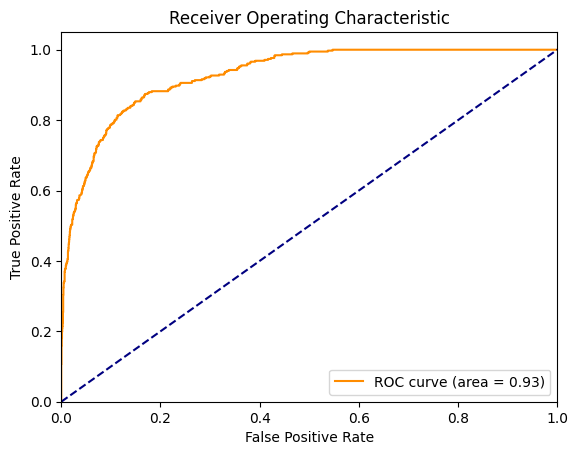

In [ ]:
os.makedirs('checkpoints', exist_ok=True)

model = models['Neural network model (8-1)']

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath=f'checkpoints/Neural network model (8-1).h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[checkpoint], verbose=0)

model.load_weights(f'checkpoints/Neural network model (8-1).h5')

y_val_pred_probs = model.predict(X_val)
y_val_pred = (y_val_pred_probs > 0.5).astype(int)

print('\nNeural network model (8-1)')

_, train_acc = model.evaluate(X_train, y_train, verbose=0)
print('\nTraining Accuracy: %.3f' % (train_acc))

_, val_acc = model.evaluate(X_val, y_val, verbose=0)
print('Validation Accuracy: %.3f' % (val_acc))

print(classification_report(y_val, y_val_pred))

fpr, tpr, _ = roc_curve(y_val, y_val_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Phase 4: Feature importance and reduction

In [ ]:
model_def = Sequential([Dense(8, input_dim=1, activation='relu'),
                        Dense(1, activation='sigmoid')])

accuracies = []

for column in X_train.columns:
    print(f'Training model with feature: {column}')

    X_train_feature = X_train[[column]]
    X_val_feature = X_val[[column]]

    model = Sequential.from_config(model_def.get_config())

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(f'model_{column}.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

    model.fit(X_train_feature, y_train, validation_data=(X_val_feature, y_val), epochs=10, verbose=1, callbacks=[checkpoint])

    _, accuracy = model.evaluate(X_val_feature, y_val, verbose=1)
    accuracies.append(accuracy)

Training model with feature: Administrative
Epoch 1/10
281/309 [==========================>...] - ETA: 0s - loss: 0.6114 - accuracy: 0.8315
Epoch 1: val_loss improved from inf to 0.51079, saving model to model_Administrative.h5
309/309 [==============================] - 1s 3ms/step - loss: 0.6028 - accuracy: 0.8335 - val_loss: 0.5108 - val_accuracy: 0.8451
Epoch 2/10
 89/309 [=======>......................] - ETA: 0s - loss: 0.5031 - accuracy: 0.8371

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


291/309 [===========================>..] - ETA: 0s - loss: 0.4701 - accuracy: 0.8444
Epoch 2: val_loss improved from 0.51079 to 0.44254, saving model to model_Administrative.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4672 - accuracy: 0.8453 - val_loss: 0.4425 - val_accuracy: 0.8451
Epoch 3/10
309/309 [==============================] - ETA: 0s - loss: 0.4382 - accuracy: 0.8453
Epoch 3: val_loss improved from 0.44254 to 0.43317, saving model to model_Administrative.h5
309/309 [==============================] - 1s 3ms/step - loss: 0.4382 - accuracy: 0.8453 - val_loss: 0.4332 - val_accuracy: 0.8451
Epoch 4/10
292/309 [===========================>..] - ETA: 0s - loss: 0.4285 - accuracy: 0.8464
Epoch 4: val_loss improved from 0.43317 to 0.42912, saving model to model_Administrative.h5
309/309 [==============================] - 1s 3ms/step - loss: 0.4302 - accuracy: 0.8453 - val_loss: 0.4291 - val_accuracy: 0.8451
Epoch 5/10
282/309 [==========================>...] - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


282/309 [==========================>...] - ETA: 0s - loss: 0.4484 - accuracy: 0.8450
Epoch 2: val_loss improved from 0.47725 to 0.43419, saving model to model_Administrative_Duration.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4468 - accuracy: 0.8453 - val_loss: 0.4342 - val_accuracy: 0.8451
Epoch 3/10
300/309 [============================>.] - ETA: 0s - loss: 0.4323 - accuracy: 0.8457
Epoch 3: val_loss improved from 0.43419 to 0.43175, saving model to model_Administrative_Duration.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4330 - accuracy: 0.8453 - val_loss: 0.4318 - val_accuracy: 0.8451
Epoch 4/10
307/309 [============================>.] - ETA: 0s - loss: 0.4317 - accuracy: 0.8449
Epoch 4: val_loss improved from 0.43175 to 0.43060, saving model to model_Administrative_Duration.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4310 - accuracy: 0.8453 - val_loss: 0.4306 - val_accuracy: 0.8451
Epoch 5/10
284/309 [=======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


307/309 [============================>.] - ETA: 0s - loss: 0.4795 - accuracy: 0.8451
Epoch 2: val_loss improved from 0.52438 to 0.44889, saving model to model_Informational.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4791 - accuracy: 0.8453 - val_loss: 0.4489 - val_accuracy: 0.8451
Epoch 3/10
280/309 [==========================>...] - ETA: 0s - loss: 0.4393 - accuracy: 0.8454
Epoch 3: val_loss improved from 0.44889 to 0.43332, saving model to model_Informational.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4389 - accuracy: 0.8453 - val_loss: 0.4333 - val_accuracy: 0.8451
Epoch 4/10
281/309 [==========================>...] - ETA: 0s - loss: 0.4323 - accuracy: 0.8450
Epoch 4: val_loss improved from 0.43332 to 0.43109, saving model to model_Informational.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4317 - accuracy: 0.8453 - val_loss: 0.4311 - val_accuracy: 0.8451
Epoch 5/10
288/309 [==========================>...] - ETA

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


286/309 [==========================>...] - ETA: 0s - loss: 0.4638 - accuracy: 0.8482
Epoch 2: val_loss improved from 0.51409 to 0.43902, saving model to model_Informational_Duration.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4658 - accuracy: 0.8453 - val_loss: 0.4390 - val_accuracy: 0.8451
Epoch 3/10
308/309 [============================>.] - ETA: 0s - loss: 0.4342 - accuracy: 0.8455
Epoch 3: val_loss improved from 0.43902 to 0.43242, saving model to model_Informational_Duration.h5
309/309 [==============================] - 1s 3ms/step - loss: 0.4345 - accuracy: 0.8453 - val_loss: 0.4324 - val_accuracy: 0.8451
Epoch 4/10
288/309 [==========================>...] - ETA: 0s - loss: 0.4298 - accuracy: 0.8466
Epoch 4: val_loss improved from 0.43242 to 0.43183, saving model to model_Informational_Duration.h5
309/309 [==============================] - 1s 3ms/step - loss: 0.4320 - accuracy: 0.8453 - val_loss: 0.4318 - val_accuracy: 0.8451
Epoch 5/10
294/309 [==========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


287/309 [==========================>...] - ETA: 0s - loss: 0.4498 - accuracy: 0.8458
Epoch 2: val_loss improved from 0.47789 to 0.43522, saving model to model_ProductRelated.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4496 - accuracy: 0.8453 - val_loss: 0.4352 - val_accuracy: 0.8451
Epoch 3/10
307/309 [============================>.] - ETA: 0s - loss: 0.4315 - accuracy: 0.8453
Epoch 3: val_loss improved from 0.43522 to 0.42923, saving model to model_ProductRelated.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4314 - accuracy: 0.8453 - val_loss: 0.4292 - val_accuracy: 0.8451
Epoch 4/10
294/309 [===========================>..] - ETA: 0s - loss: 0.4241 - accuracy: 0.8464
Epoch 4: val_loss improved from 0.42923 to 0.42644, saving model to model_ProductRelated.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4260 - accuracy: 0.8453 - val_loss: 0.4264 - val_accuracy: 0.8447
Epoch 5/10
282/309 [==========================>...] - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


283/309 [==========================>...] - ETA: 0s - loss: 0.4391 - accuracy: 0.8460
Epoch 2: val_loss improved from 0.45675 to 0.43345, saving model to model_ProductRelated_Duration.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4397 - accuracy: 0.8453 - val_loss: 0.4335 - val_accuracy: 0.8451
Epoch 3/10
294/309 [===========================>..] - ETA: 0s - loss: 0.4327 - accuracy: 0.8451
Epoch 3: val_loss improved from 0.43345 to 0.43127, saving model to model_ProductRelated_Duration.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4323 - accuracy: 0.8453 - val_loss: 0.4313 - val_accuracy: 0.8451
Epoch 4/10
282/309 [==========================>...] - ETA: 0s - loss: 0.4311 - accuracy: 0.8446
Epoch 4: val_loss improved from 0.43127 to 0.42944, saving model to model_ProductRelated_Duration.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4299 - accuracy: 0.8453 - val_loss: 0.4294 - val_accuracy: 0.8451
Epoch 5/10
283/309 [=======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


301/309 [============================>.] - ETA: 0s - loss: 0.4259 - accuracy: 0.8466
Epoch 2: val_loss improved from 0.45746 to 0.41637, saving model to model_BounceRates.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4274 - accuracy: 0.8453 - val_loss: 0.4164 - val_accuracy: 0.8451
Epoch 3/10
305/309 [============================>.] - ETA: 0s - loss: 0.4144 - accuracy: 0.8454
Epoch 3: val_loss improved from 0.41637 to 0.41435, saving model to model_BounceRates.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4146 - accuracy: 0.8453 - val_loss: 0.4144 - val_accuracy: 0.8451
Epoch 4/10
292/309 [===========================>..] - ETA: 0s - loss: 0.4151 - accuracy: 0.8443
Epoch 4: val_loss improved from 0.41435 to 0.41350, saving model to model_BounceRates.h5
309/309 [==============================] - 1s 3ms/step - loss: 0.4133 - accuracy: 0.8453 - val_loss: 0.4135 - val_accuracy: 0.8451
Epoch 5/10
298/309 [===========================>..] - ETA: 0s -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


307/309 [============================>.] - ETA: 0s - loss: 0.4427 - accuracy: 0.8452
Epoch 2: val_loss improved from 0.49806 to 0.41506, saving model to model_ExitRates.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4424 - accuracy: 0.8453 - val_loss: 0.4151 - val_accuracy: 0.8451
Epoch 3/10
281/309 [==========================>...] - ETA: 0s - loss: 0.4132 - accuracy: 0.8433
Epoch 3: val_loss improved from 0.41506 to 0.40794, saving model to model_ExitRates.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4097 - accuracy: 0.8453 - val_loss: 0.4079 - val_accuracy: 0.8451
Epoch 4/10
282/309 [==========================>...] - ETA: 0s - loss: 0.4085 - accuracy: 0.8440
Epoch 4: val_loss improved from 0.40794 to 0.40594, saving model to model_ExitRates.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4061 - accuracy: 0.8453 - val_loss: 0.4059 - val_accuracy: 0.8451
Epoch 5/10
298/309 [===========================>..] - ETA: 0s - loss:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


304/309 [============================>.] - ETA: 0s - loss: 0.5664 - accuracy: 0.8477
Epoch 2: val_loss improved from 0.60099 to 0.53302, saving model to model_PageValues.h5
309/309 [==============================] - 1s 4ms/step - loss: 0.5659 - accuracy: 0.8477 - val_loss: 0.5330 - val_accuracy: 0.8487
Epoch 3/10
303/309 [============================>.] - ETA: 0s - loss: 0.5077 - accuracy: 0.8499
Epoch 3: val_loss improved from 0.53302 to 0.48200, saving model to model_PageValues.h5
309/309 [==============================] - 2s 6ms/step - loss: 0.5074 - accuracy: 0.8500 - val_loss: 0.4820 - val_accuracy: 0.8520
Epoch 4/10
304/309 [============================>.] - ETA: 0s - loss: 0.4636 - accuracy: 0.8532
Epoch 4: val_loss improved from 0.48200 to 0.44267, saving model to model_PageValues.h5
309/309 [==============================] - 1s 3ms/step - loss: 0.4634 - accuracy: 0.8531 - val_loss: 0.4427 - val_accuracy: 0.8548
Epoch 5/10
304/309 [============================>.] - ETA: 0s - lo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


289/309 [===========================>..] - ETA: 0s - loss: 0.4325 - accuracy: 0.8449
Epoch 2: val_loss improved from 0.44842 to 0.42599, saving model to model_SpecialDay.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4315 - accuracy: 0.8453 - val_loss: 0.4260 - val_accuracy: 0.8451
Epoch 3/10
286/309 [==========================>...] - ETA: 0s - loss: 0.4262 - accuracy: 0.8458
Epoch 3: val_loss did not improve from 0.42599
309/309 [==============================] - 1s 2ms/step - loss: 0.4267 - accuracy: 0.8453 - val_loss: 0.4260 - val_accuracy: 0.8451
Epoch 4/10
295/309 [===========================>..] - ETA: 0s - loss: 0.4273 - accuracy: 0.8450
Epoch 4: val_loss improved from 0.42599 to 0.42597, saving model to model_SpecialDay.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4268 - accuracy: 0.8453 - val_loss: 0.4260 - val_accuracy: 0.8451
Epoch 5/10
296/309 [===========================>..] - ETA: 0s - loss: 0.4263 - accuracy: 0.8454
Epoch 5: va

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


297/309 [===========================>..] - ETA: 0s - loss: 0.4444 - accuracy: 0.8455
Epoch 2: val_loss improved from 0.47247 to 0.43481, saving model to model_OperatingSystems.h5
309/309 [==============================] - 1s 3ms/step - loss: 0.4443 - accuracy: 0.8453 - val_loss: 0.4348 - val_accuracy: 0.8451
Epoch 3/10
290/309 [===========================>..] - ETA: 0s - loss: 0.4318 - accuracy: 0.8458
Epoch 3: val_loss improved from 0.43481 to 0.43364, saving model to model_OperatingSystems.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4328 - accuracy: 0.8453 - val_loss: 0.4336 - val_accuracy: 0.8451
Epoch 4/10
291/309 [===========================>..] - ETA: 0s - loss: 0.4304 - accuracy: 0.8461
Epoch 4: val_loss improved from 0.43364 to 0.43334, saving model to model_OperatingSystems.h5
309/309 [==============================] - 1s 3ms/step - loss: 0.4323 - accuracy: 0.8453 - val_loss: 0.4333 - val_accuracy: 0.8451
Epoch 5/10
308/309 [============================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


290/309 [===========================>..] - ETA: 0s - loss: 0.4534 - accuracy: 0.8456
Epoch 2: val_loss improved from 0.48326 to 0.43773, saving model to model_Browser.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4529 - accuracy: 0.8453 - val_loss: 0.4377 - val_accuracy: 0.8451
Epoch 3/10
290/309 [===========================>..] - ETA: 0s - loss: 0.4369 - accuracy: 0.8446
Epoch 3: val_loss improved from 0.43773 to 0.43377, saving model to model_Browser.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4355 - accuracy: 0.8453 - val_loss: 0.4338 - val_accuracy: 0.8451
Epoch 4/10
307/309 [============================>.] - ETA: 0s - loss: 0.4336 - accuracy: 0.8451
Epoch 4: val_loss improved from 0.43377 to 0.43248, saving model to model_Browser.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4332 - accuracy: 0.8453 - val_loss: 0.4325 - val_accuracy: 0.8451
Epoch 5/10
306/309 [============================>.] - ETA: 0s - loss: 0.431

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


283/309 [==========================>...] - ETA: 0s - loss: 0.4472 - accuracy: 0.8438
Epoch 2: val_loss improved from 0.45626 to 0.43843, saving model to model_Region.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4443 - accuracy: 0.8453 - val_loss: 0.4384 - val_accuracy: 0.8451
Epoch 3/10
308/309 [============================>.] - ETA: 0s - loss: 0.4374 - accuracy: 0.8452
Epoch 3: val_loss improved from 0.43843 to 0.43500, saving model to model_Region.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4371 - accuracy: 0.8453 - val_loss: 0.4350 - val_accuracy: 0.8451
Epoch 4/10
302/309 [============================>.] - ETA: 0s - loss: 0.4352 - accuracy: 0.8448
Epoch 4: val_loss improved from 0.43500 to 0.43311, saving model to model_Region.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4344 - accuracy: 0.8453 - val_loss: 0.4331 - val_accuracy: 0.8451
Epoch 5/10
292/309 [===========================>..] - ETA: 0s - loss: 0.4288 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


308/309 [============================>.] - ETA: 0s - loss: 0.5746 - accuracy: 0.8452
Epoch 2: val_loss improved from 0.60856 to 0.54439, saving model to model_TrafficType.h5
309/309 [==============================] - 1s 3ms/step - loss: 0.5745 - accuracy: 0.8453 - val_loss: 0.5444 - val_accuracy: 0.8451
Epoch 3/10
286/309 [==========================>...] - ETA: 0s - loss: 0.5218 - accuracy: 0.8474
Epoch 3: val_loss improved from 0.54439 to 0.50223, saving model to model_TrafficType.h5
309/309 [==============================] - 1s 3ms/step - loss: 0.5219 - accuracy: 0.8453 - val_loss: 0.5022 - val_accuracy: 0.8451
Epoch 4/10
302/309 [============================>.] - ETA: 0s - loss: 0.4875 - accuracy: 0.8456
Epoch 4: val_loss improved from 0.50223 to 0.47470, saving model to model_TrafficType.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4875 - accuracy: 0.8453 - val_loss: 0.4747 - val_accuracy: 0.8451
Epoch 5/10
303/309 [============================>.] - ETA: 0s -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


306/309 [============================>.] - ETA: 0s - loss: 0.4946 - accuracy: 0.8450
Epoch 2: val_loss improved from 0.53354 to 0.46481, saving model to model_Weekend.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4940 - accuracy: 0.8453 - val_loss: 0.4648 - val_accuracy: 0.8451
Epoch 3/10
292/309 [===========================>..] - ETA: 0s - loss: 0.4553 - accuracy: 0.8443
Epoch 3: val_loss improved from 0.46481 to 0.44388, saving model to model_Weekend.h5
309/309 [==============================] - 1s 3ms/step - loss: 0.4531 - accuracy: 0.8453 - val_loss: 0.4439 - val_accuracy: 0.8451
Epoch 4/10
294/309 [===========================>..] - ETA: 0s - loss: 0.4407 - accuracy: 0.8451
Epoch 4: val_loss improved from 0.44388 to 0.43634, saving model to model_Weekend.h5
309/309 [==============================] - 1s 3ms/step - loss: 0.4402 - accuracy: 0.8453 - val_loss: 0.4363 - val_accuracy: 0.8451
Epoch 5/10
308/309 [============================>.] - ETA: 0s - loss: 0.434

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


286/309 [==========================>...] - ETA: 0s - loss: 0.4644 - accuracy: 0.8451
Epoch 2: val_loss improved from 0.51020 to 0.43575, saving model to model_Month_Feb.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4622 - accuracy: 0.8453 - val_loss: 0.4358 - val_accuracy: 0.8451
Epoch 3/10
287/309 [==========================>...] - ETA: 0s - loss: 0.4301 - accuracy: 0.8460
Epoch 3: val_loss improved from 0.43575 to 0.42919, saving model to model_Month_Feb.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4311 - accuracy: 0.8453 - val_loss: 0.4292 - val_accuracy: 0.8451
Epoch 4/10
303/309 [============================>.] - ETA: 0s - loss: 0.4301 - accuracy: 0.8449
Epoch 4: val_loss improved from 0.42919 to 0.42911, saving model to model_Month_Feb.h5
309/309 [==============================] - 1s 3ms/step - loss: 0.4293 - accuracy: 0.8453 - val_loss: 0.4291 - val_accuracy: 0.8451
Epoch 5/10
308/309 [============================>.] - ETA: 0s - loss:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


289/309 [===========================>..] - ETA: 0s - loss: 0.4546 - accuracy: 0.8438
Epoch 2: val_loss improved from 0.48304 to 0.42967, saving model to model_Month_Mar.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4517 - accuracy: 0.8453 - val_loss: 0.4297 - val_accuracy: 0.8451
Epoch 3/10
287/309 [==========================>...] - ETA: 0s - loss: 0.4346 - accuracy: 0.8435
Epoch 3: val_loss improved from 0.42967 to 0.42602, saving model to model_Month_Mar.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4317 - accuracy: 0.8453 - val_loss: 0.4260 - val_accuracy: 0.8451
Epoch 4/10
283/309 [==========================>...] - ETA: 0s - loss: 0.4306 - accuracy: 0.8450
Epoch 4: val_loss did not improve from 0.42602
309/309 [==============================] - 1s 2ms/step - loss: 0.4300 - accuracy: 0.8453 - val_loss: 0.4262 - val_accuracy: 0.8451
Epoch 5/10
282/309 [==========================>...] - ETA: 0s - loss: 0.4313 - accuracy: 0.8441
Epoch 5: val_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


287/309 [==========================>...] - ETA: 0s - loss: 0.4505 - accuracy: 0.8445
Epoch 2: val_loss improved from 0.48420 to 0.43184, saving model to model_Month_May.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4480 - accuracy: 0.8453 - val_loss: 0.4318 - val_accuracy: 0.8451
Epoch 3/10
308/309 [============================>.] - ETA: 0s - loss: 0.4296 - accuracy: 0.8453
Epoch 3: val_loss improved from 0.43184 to 0.42854, saving model to model_Month_May.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4296 - accuracy: 0.8453 - val_loss: 0.4285 - val_accuracy: 0.8451
Epoch 4/10
296/309 [===========================>..] - ETA: 0s - loss: 0.4270 - accuracy: 0.8461
Epoch 4: val_loss improved from 0.42854 to 0.42804, saving model to model_Month_May.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4283 - accuracy: 0.8453 - val_loss: 0.4280 - val_accuracy: 0.8451
Epoch 5/10
294/309 [===========================>..] - ETA: 0s - loss:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


292/309 [===========================>..] - ETA: 0s - loss: 0.4598 - accuracy: 0.8447
Epoch 2: val_loss improved from 0.49859 to 0.43927, saving model to model_Month_Oct.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4579 - accuracy: 0.8453 - val_loss: 0.4393 - val_accuracy: 0.8451
Epoch 3/10
297/309 [===========================>..] - ETA: 0s - loss: 0.4327 - accuracy: 0.8459
Epoch 3: val_loss improved from 0.43927 to 0.43267, saving model to model_Month_Oct.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4336 - accuracy: 0.8453 - val_loss: 0.4327 - val_accuracy: 0.8451
Epoch 4/10
297/309 [===========================>..] - ETA: 0s - loss: 0.4298 - accuracy: 0.8462
Epoch 4: val_loss improved from 0.43267 to 0.43134, saving model to model_Month_Oct.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4313 - accuracy: 0.8453 - val_loss: 0.4313 - val_accuracy: 0.8451
Epoch 5/10
301/309 [============================>.] - ETA: 0s - loss:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


305/309 [============================>.] - ETA: 0s - loss: 0.4560 - accuracy: 0.8453
Epoch 2: val_loss improved from 0.49528 to 0.43722, saving model to model_Month_June.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4558 - accuracy: 0.8453 - val_loss: 0.4372 - val_accuracy: 0.8451
Epoch 3/10
295/309 [===========================>..] - ETA: 0s - loss: 0.4318 - accuracy: 0.8457
Epoch 3: val_loss improved from 0.43722 to 0.43239, saving model to model_Month_June.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4322 - accuracy: 0.8453 - val_loss: 0.4324 - val_accuracy: 0.8451
Epoch 4/10
285/309 [==========================>...] - ETA: 0s - loss: 0.4298 - accuracy: 0.8457
Epoch 4: val_loss improved from 0.43239 to 0.43203, saving model to model_Month_June.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4307 - accuracy: 0.8453 - val_loss: 0.4320 - val_accuracy: 0.8451
Epoch 5/10
304/309 [============================>.] - ETA: 0s - lo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


309/309 [==============================] - ETA: 0s - loss: 0.4876 - accuracy: 0.8453
Epoch 2: val_loss improved from 0.53812 to 0.45277, saving model to model_Month_Jul.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4876 - accuracy: 0.8453 - val_loss: 0.4528 - val_accuracy: 0.8451
Epoch 3/10
304/309 [============================>.] - ETA: 0s - loss: 0.4403 - accuracy: 0.8455
Epoch 3: val_loss improved from 0.45277 to 0.43448, saving model to model_Month_Jul.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4405 - accuracy: 0.8453 - val_loss: 0.4345 - val_accuracy: 0.8451
Epoch 4/10
300/309 [============================>.] - ETA: 0s - loss: 0.4324 - accuracy: 0.8454
Epoch 4: val_loss improved from 0.43448 to 0.43227, saving model to model_Month_Jul.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4326 - accuracy: 0.8453 - val_loss: 0.4323 - val_accuracy: 0.8451
Epoch 5/10
309/309 [==============================] - ETA: 0s - loss:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


307/309 [============================>.] - ETA: 0s - loss: 0.4632 - accuracy: 0.8453
Epoch 2: val_loss improved from 0.51013 to 0.43966, saving model to model_Month_Aug.h5
309/309 [==============================] - 1s 3ms/step - loss: 0.4631 - accuracy: 0.8453 - val_loss: 0.4397 - val_accuracy: 0.8451
Epoch 3/10
285/309 [==========================>...] - ETA: 0s - loss: 0.4364 - accuracy: 0.8439
Epoch 3: val_loss improved from 0.43966 to 0.43319, saving model to model_Month_Aug.h5
309/309 [==============================] - 1s 3ms/step - loss: 0.4340 - accuracy: 0.8453 - val_loss: 0.4332 - val_accuracy: 0.8451
Epoch 4/10
279/309 [==========================>...] - ETA: 0s - loss: 0.4342 - accuracy: 0.8439
Epoch 4: val_loss improved from 0.43319 to 0.43221, saving model to model_Month_Aug.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4317 - accuracy: 0.8453 - val_loss: 0.4322 - val_accuracy: 0.8451
Epoch 5/10
296/309 [===========================>..] - ETA: 0s - loss:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


300/309 [============================>.] - ETA: 0s - loss: 0.4464 - accuracy: 0.8448
Epoch 2: val_loss improved from 0.47316 to 0.42872, saving model to model_Month_Nov.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4452 - accuracy: 0.8453 - val_loss: 0.4287 - val_accuracy: 0.8451
Epoch 3/10
302/309 [============================>.] - ETA: 0s - loss: 0.4227 - accuracy: 0.8452
Epoch 3: val_loss improved from 0.42872 to 0.42363, saving model to model_Month_Nov.h5
309/309 [==============================] - 1s 3ms/step - loss: 0.4228 - accuracy: 0.8453 - val_loss: 0.4236 - val_accuracy: 0.8451
Epoch 4/10
297/309 [===========================>..] - ETA: 0s - loss: 0.4205 - accuracy: 0.8447
Epoch 4: val_loss improved from 0.42363 to 0.42346, saving model to model_Month_Nov.h5
309/309 [==============================] - 1s 3ms/step - loss: 0.4196 - accuracy: 0.8453 - val_loss: 0.4235 - val_accuracy: 0.8451
Epoch 5/10
297/309 [===========================>..] - ETA: 0s - loss:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


307/309 [============================>.] - ETA: 0s - loss: 0.4870 - accuracy: 0.8453
Epoch 2: val_loss improved from 0.53657 to 0.45331, saving model to model_Month_Sep.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4868 - accuracy: 0.8453 - val_loss: 0.4533 - val_accuracy: 0.8451
Epoch 3/10
284/309 [==========================>...] - ETA: 0s - loss: 0.4413 - accuracy: 0.8447
Epoch 3: val_loss improved from 0.45331 to 0.43445, saving model to model_Month_Sep.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4400 - accuracy: 0.8453 - val_loss: 0.4344 - val_accuracy: 0.8451
Epoch 4/10
305/309 [============================>.] - ETA: 0s - loss: 0.4323 - accuracy: 0.8452
Epoch 4: val_loss improved from 0.43445 to 0.43213, saving model to model_Month_Sep.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4320 - accuracy: 0.8453 - val_loss: 0.4321 - val_accuracy: 0.8451
Epoch 5/10
290/309 [===========================>..] - ETA: 0s - loss:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


306/309 [============================>.] - ETA: 0s - loss: 0.4458 - accuracy: 0.8448
Epoch 2: val_loss improved from 0.46951 to 0.44027, saving model to model_Month_Dec.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4450 - accuracy: 0.8453 - val_loss: 0.4403 - val_accuracy: 0.8451
Epoch 3/10
298/309 [===========================>..] - ETA: 0s - loss: 0.4325 - accuracy: 0.8458
Epoch 3: val_loss improved from 0.44027 to 0.43444, saving model to model_Month_Dec.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4333 - accuracy: 0.8453 - val_loss: 0.4344 - val_accuracy: 0.8451
Epoch 4/10
282/309 [==========================>...] - ETA: 0s - loss: 0.4310 - accuracy: 0.8455
Epoch 4: val_loss improved from 0.43444 to 0.43251, saving model to model_Month_Dec.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4311 - accuracy: 0.8453 - val_loss: 0.4325 - val_accuracy: 0.8451
Epoch 5/10
283/309 [==========================>...] - ETA: 0s - loss:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


307/309 [============================>.] - ETA: 0s - loss: 0.4495 - accuracy: 0.8450
Epoch 2: val_loss improved from 0.48436 to 0.43160, saving model to model_VisitorType_Returning_Visitor.h5
309/309 [==============================] - 1s 3ms/step - loss: 0.4491 - accuracy: 0.8453 - val_loss: 0.4316 - val_accuracy: 0.8451
Epoch 3/10
283/309 [==========================>...] - ETA: 0s - loss: 0.4287 - accuracy: 0.8449
Epoch 3: val_loss improved from 0.43160 to 0.42667, saving model to model_VisitorType_Returning_Visitor.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4276 - accuracy: 0.8453 - val_loss: 0.4267 - val_accuracy: 0.8451
Epoch 4/10
280/309 [==========================>...] - ETA: 0s - loss: 0.4266 - accuracy: 0.8450
Epoch 4: val_loss improved from 0.42667 to 0.42648, saving model to model_VisitorType_Returning_Visitor.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4263 - accuracy: 0.8453 - val_loss: 0.4265 - val_accuracy: 0.8451
Epoch 5/1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


307/309 [============================>.] - ETA: 0s - loss: 0.4595 - accuracy: 0.8455
Epoch 2: val_loss improved from 0.49889 to 0.43990, saving model to model_VisitorType_New_Visitor.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4597 - accuracy: 0.8453 - val_loss: 0.4399 - val_accuracy: 0.8451
Epoch 3/10
282/309 [==========================>...] - ETA: 0s - loss: 0.4354 - accuracy: 0.8445
Epoch 3: val_loss improved from 0.43990 to 0.42995, saving model to model_VisitorType_New_Visitor.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4338 - accuracy: 0.8453 - val_loss: 0.4300 - val_accuracy: 0.8451
Epoch 4/10
306/309 [============================>.] - ETA: 0s - loss: 0.4282 - accuracy: 0.8452
Epoch 4: val_loss improved from 0.42995 to 0.42694, saving model to model_VisitorType_New_Visitor.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4280 - accuracy: 0.8453 - val_loss: 0.4269 - val_accuracy: 0.8451
Epoch 5/10
299/309 [=======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


307/309 [============================>.] - ETA: 0s - loss: 0.4418 - accuracy: 0.8456
Epoch 2: val_loss improved from 0.47417 to 0.43170, saving model to model_VisitorType_Other.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4422 - accuracy: 0.8453 - val_loss: 0.4317 - val_accuracy: 0.8451
Epoch 3/10
303/309 [============================>.] - ETA: 0s - loss: 0.4315 - accuracy: 0.8451
Epoch 3: val_loss improved from 0.43170 to 0.43121, saving model to model_VisitorType_Other.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4311 - accuracy: 0.8453 - val_loss: 0.4312 - val_accuracy: 0.8451
Epoch 4/10
302/309 [============================>.] - ETA: 0s - loss: 0.4312 - accuracy: 0.8452
Epoch 4: val_loss improved from 0.43121 to 0.43119, saving model to model_VisitorType_Other.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4310 - accuracy: 0.8453 - val_loss: 0.4312 - val_accuracy: 0.8451
Epoch 5/10
308/309 [=========================

Administrative: 0.8438767194747925
Administrative_Duration: 0.8438767194747925
Informational: 0.8450932502746582
Informational_Duration: 0.8450932502746582
ProductRelated: 0.8426601886749268
ProductRelated_Duration: 0.8442822098731995
BounceRates: 0.8450932502746582
ExitRates: 0.8450932502746582
PageValues: 0.8751013875007629
SpecialDay: 0.8450932502746582
OperatingSystems: 0.8450932502746582
Browser: 0.8450932502746582
Region: 0.8450932502746582
TrafficType: 0.8450932502746582
Weekend: 0.8450932502746582
Month_Feb: 0.8450932502746582
Month_Mar: 0.8450932502746582
Month_May: 0.8450932502746582
Month_Oct: 0.8450932502746582
Month_June: 0.8450932502746582
Month_Jul: 0.8450932502746582
Month_Aug: 0.8450932502746582
Month_Nov: 0.8450932502746582
Month_Sep: 0.8450932502746582
Month_Dec: 0.8450932502746582
VisitorType_Returning_Visitor: 0.8450932502746582
VisitorType_New_Visitor: 0.8450932502746582
VisitorType_Other: 0.8450932502746582


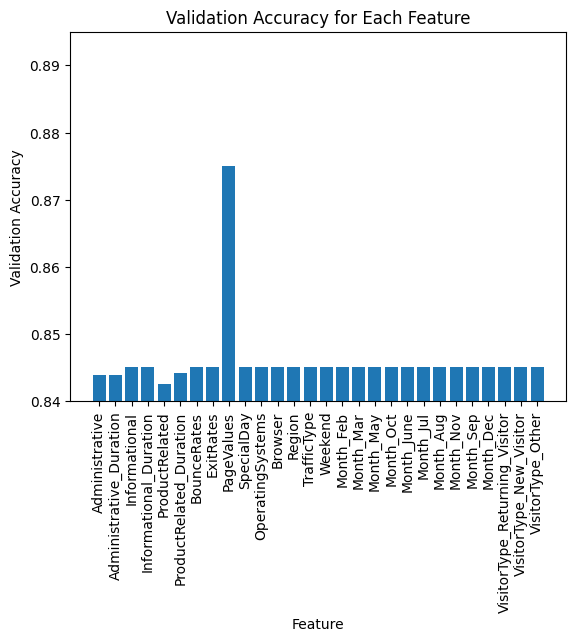

In [ ]:
# Plot the accuracies in a bar diagram
for column, accuracy in zip(X_train.columns, accuracies):
    print(f'{column}: {accuracy}')
plt.bar(X_train.columns, accuracies)
plt.ylim(0.84, .895)
plt.xlabel('Feature')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Each Feature')
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
dropAccuracies = []

X_train = X_train.drop('ProductRelated', axis=1)
X_val = X_val.drop('ProductRelated', axis=1)

model = Sequential()
model.add(Dense(8, input_dim=27, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('model_all_except_product_related.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, verbose=1, callbacks=[checkpoint])

_, accuracy = model.evaluate(X_val, y_val, verbose=1)
dropAccuracies.append(accuracy)

Epoch 1/25
288/309 [==========================>...] - ETA: 0s - loss: 0.5044 - accuracy: 0.7896
Epoch 1: val_loss improved from inf to 0.41111, saving model to model_all_except_product_related.h5
309/309 [==============================] - 1s 3ms/step - loss: 0.4978 - accuracy: 0.7939 - val_loss: 0.4111 - val_accuracy: 0.8451
Epoch 2/25
 97/309 [========>.....................] - ETA: 0s - loss: 0.4056 - accuracy: 0.8489

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


280/309 [==========================>...] - ETA: 0s - loss: 0.4017 - accuracy: 0.8461
Epoch 2: val_loss improved from 0.41111 to 0.38980, saving model to model_all_except_product_related.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4022 - accuracy: 0.8453 - val_loss: 0.3898 - val_accuracy: 0.8451
Epoch 3/25
287/309 [==========================>...] - ETA: 0s - loss: 0.3820 - accuracy: 0.8458
Epoch 3: val_loss improved from 0.38980 to 0.37301, saving model to model_all_except_product_related.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.3814 - accuracy: 0.8459 - val_loss: 0.3730 - val_accuracy: 0.8451
Epoch 4/25
305/309 [============================>.] - ETA: 0s - loss: 0.3650 - accuracy: 0.8475
Epoch 4: val_loss improved from 0.37301 to 0.35942, saving model to model_all_except_product_related.h5
309/309 [==============================] - 1s 3ms/step - loss: 0.3646 - accuracy: 0.8476 - val_loss: 0.3594 - val_accuracy: 0.8463
Epoch 5/25
297/309

In [ ]:
X_train = X_train.drop(['ProductRelated_Duration', 'Administrative'], axis=1)
X_val = X_val.drop(['ProductRelated_Duration', 'Administrative'], axis=1)

model = Sequential()
model.add(Dense(8, input_dim=25, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('model_drop_two_features.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, verbose=1, callbacks=[checkpoint])

_, accuracy = model.evaluate(X_val, y_val, verbose=1)
dropAccuracies.append(accuracy)

Epoch 1/25
296/309 [===========================>..] - ETA: 0s - loss: 0.4977 - accuracy: 0.8100
Epoch 1: val_loss improved from inf to 0.40137, saving model to model_drop_two_features.h5
309/309 [==============================] - 1s 3ms/step - loss: 0.4931 - accuracy: 0.8122 - val_loss: 0.4014 - val_accuracy: 0.8451
Epoch 2/25
 99/309 [========>.....................] - ETA: 0s - loss: 0.4007 - accuracy: 0.8450

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


288/309 [==========================>...] - ETA: 0s - loss: 0.3916 - accuracy: 0.8456
Epoch 2: val_loss improved from 0.40137 to 0.38207, saving model to model_drop_two_features.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.3910 - accuracy: 0.8455 - val_loss: 0.3821 - val_accuracy: 0.8451
Epoch 3/25
282/309 [==========================>...] - ETA: 0s - loss: 0.3718 - accuracy: 0.8483
Epoch 3: val_loss improved from 0.38207 to 0.36706, saving model to model_drop_two_features.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.3728 - accuracy: 0.8468 - val_loss: 0.3671 - val_accuracy: 0.8467
Epoch 4/25
309/309 [==============================] - ETA: 0s - loss: 0.3583 - accuracy: 0.8498
Epoch 4: val_loss improved from 0.36706 to 0.35365, saving model to model_drop_two_features.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.3583 - accuracy: 0.8498 - val_loss: 0.3537 - val_accuracy: 0.8532
Epoch 5/25
291/309 [=========================

In [ ]:
X_train = X_train.drop(['Administrative_Duration', 'Informational_Duration', 'Informational'], axis=1)
X_val = X_val.drop(['Administrative_Duration', 'Informational_Duration', 'Informational'], axis=1)

model = Sequential()
model.add(Dense(8, input_dim=22, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('model_drop_three_features.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, verbose=1, callbacks=[checkpoint])

_, accuracy = model.evaluate(X_val, y_val, verbose=1)
dropAccuracies.append(accuracy)

Epoch 1/25
301/309 [============================>.] - ETA: 0s - loss: 0.4584 - accuracy: 0.8369
Epoch 1: val_loss improved from inf to 0.39788, saving model to model_drop_three_features.h5
309/309 [==============================] - 2s 3ms/step - loss: 0.4555 - accuracy: 0.8379 - val_loss: 0.3979 - val_accuracy: 0.8451
Epoch 2/25
 84/309 [=======>......................] - ETA: 0s - loss: 0.3981 - accuracy: 0.8449

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


306/309 [============================>.] - ETA: 0s - loss: 0.3894 - accuracy: 0.8451
Epoch 2: val_loss improved from 0.39788 to 0.37881, saving model to model_drop_three_features.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.3889 - accuracy: 0.8453 - val_loss: 0.3788 - val_accuracy: 0.8451
Epoch 3/25
277/309 [=========================>....] - ETA: 0s - loss: 0.3761 - accuracy: 0.8440
Epoch 3: val_loss improved from 0.37881 to 0.36862, saving model to model_drop_three_features.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.3739 - accuracy: 0.8454 - val_loss: 0.3686 - val_accuracy: 0.8455
Epoch 4/25
300/309 [============================>.] - ETA: 0s - loss: 0.3643 - accuracy: 0.8458
Epoch 4: val_loss improved from 0.36862 to 0.35901, saving model to model_drop_three_features.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.3640 - accuracy: 0.8461 - val_loss: 0.3590 - val_accuracy: 0.8475
Epoch 5/25
293/309 [===================

In [ ]:
columns_to_drop = ["BounceRates", "ExitRates", "SpecialDay", "OperatingSystems"]
X_train = X_train.drop(columns_to_drop, axis=1)
X_val = X_val.drop(columns_to_drop, axis=1)

model = Sequential()
model.add(Dense(8, input_dim=18, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('model_drop_four_features.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, verbose=1, callbacks=[checkpoint])

_, accuracy = model.evaluate(X_val, y_val, verbose=1)
dropAccuracies.append(accuracy)

Epoch 1/25
278/309 [=========================>....] - ETA: 0s - loss: 0.5230 - accuracy: 0.7936
Epoch 1: val_loss improved from inf to 0.43210, saving model to model_drop_four_features.h5
309/309 [==============================] - 2s 3ms/step - loss: 0.5131 - accuracy: 0.7997 - val_loss: 0.4321 - val_accuracy: 0.8451
Epoch 2/25
 95/309 [========>.....................] - ETA: 0s - loss: 0.4384 - accuracy: 0.8378

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


303/309 [============================>.] - ETA: 0s - loss: 0.4187 - accuracy: 0.8450
Epoch 2: val_loss improved from 0.43210 to 0.40758, saving model to model_drop_four_features.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4180 - accuracy: 0.8453 - val_loss: 0.4076 - val_accuracy: 0.8451
Epoch 3/25
284/309 [==========================>...] - ETA: 0s - loss: 0.4000 - accuracy: 0.8458
Epoch 3: val_loss improved from 0.40758 to 0.39481, saving model to model_drop_four_features.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.3997 - accuracy: 0.8460 - val_loss: 0.3948 - val_accuracy: 0.8451
Epoch 4/25
288/309 [==========================>...] - ETA: 0s - loss: 0.3884 - accuracy: 0.8461
Epoch 4: val_loss improved from 0.39481 to 0.38283, saving model to model_drop_four_features.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.3872 - accuracy: 0.8465 - val_loss: 0.3828 - val_accuracy: 0.8496
Epoch 5/25
289/309 [======================

In [ ]:
columns_to_drop = ["Browser", "Region", "TrafficType", "Weekend", "Month_Feb", "Month_Mar", "Month_May", "Month_Oct", "Month_June", "Month_Jul", "Month_Aug", "Month_Nov", "Month_Sep", "Month_Dec"]
X_train = X_train.drop(columns_to_drop, axis=1)
X_val = X_val.drop(columns_to_drop, axis=1)

model = Sequential()
model.add(Dense(8, input_dim=4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('model_drop_five_features.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, verbose=1, callbacks=[checkpoint])

_, accuracy = model.evaluate(X_val, y_val, verbose=1)
dropAccuracies.append(accuracy)

Epoch 1/25
288/309 [==========================>...] - ETA: 0s - loss: 0.6368 - accuracy: 0.6850
Epoch 1: val_loss improved from inf to 0.52583, saving model to model_drop_five_features.h5
309/309 [==============================] - 1s 3ms/step - loss: 0.6306 - accuracy: 0.6943 - val_loss: 0.5258 - val_accuracy: 0.8459
Epoch 2/25
 99/309 [========>.....................] - ETA: 0s - loss: 0.5020 - accuracy: 0.8450

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


296/309 [===========================>..] - ETA: 0s - loss: 0.4641 - accuracy: 0.8461
Epoch 2: val_loss improved from 0.52583 to 0.42143, saving model to model_drop_five_features.h5
309/309 [==============================] - 1s 3ms/step - loss: 0.4626 - accuracy: 0.8460 - val_loss: 0.4214 - val_accuracy: 0.8459
Epoch 3/25
299/309 [============================>.] - ETA: 0s - loss: 0.4087 - accuracy: 0.8462
Epoch 3: val_loss improved from 0.42143 to 0.39697, saving model to model_drop_five_features.h5
309/309 [==============================] - 1s 3ms/step - loss: 0.4079 - accuracy: 0.8465 - val_loss: 0.3970 - val_accuracy: 0.8475
Epoch 4/25
291/309 [===========================>..] - ETA: 0s - loss: 0.3905 - accuracy: 0.8489
Epoch 4: val_loss improved from 0.39697 to 0.37636, saving model to model_drop_five_features.h5
309/309 [==============================] - 1s 3ms/step - loss: 0.3899 - accuracy: 0.8489 - val_loss: 0.3764 - val_accuracy: 0.8532
Epoch 5/25
295/309 [======================

In [ ]:
columns_to_drop = ["VisitorType_Returning_Visitor", "VisitorType_New_Visitor", "VisitorType_Other"]
X_train = X_train.drop(columns_to_drop, axis=1)
X_val = X_val.drop(columns_to_drop, axis=1)

model = Sequential()
model.add(Dense(8, input_dim=1, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('model_drop_six_features.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, verbose=1, callbacks=[checkpoint])

_, accuracy = model.evaluate(X_val, y_val, verbose=1)
dropAccuracies.append(accuracy)

Epoch 1/25
299/309 [============================>.] - ETA: 0s - loss: 0.6476 - accuracy: 0.8462
Epoch 1: val_loss improved from inf to 0.60189, saving model to model_drop_six_features.h5
309/309 [==============================] - 1s 3ms/step - loss: 0.6464 - accuracy: 0.8461 - val_loss: 0.6019 - val_accuracy: 0.8471
Epoch 2/25
103/309 [=========>....................] - ETA: 0s - loss: 0.5883 - accuracy: 0.8501

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


293/309 [===========================>..] - ETA: 0s - loss: 0.5683 - accuracy: 0.8474
Epoch 2: val_loss improved from 0.60189 to 0.53356, saving model to model_drop_six_features.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.5666 - accuracy: 0.8475 - val_loss: 0.5336 - val_accuracy: 0.8496
Epoch 3/25
287/309 [==========================>...] - ETA: 0s - loss: 0.5095 - accuracy: 0.8491
Epoch 3: val_loss improved from 0.53356 to 0.48236, saving model to model_drop_six_features.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.5077 - accuracy: 0.8494 - val_loss: 0.4824 - val_accuracy: 0.8520
Epoch 4/25
287/309 [==========================>...] - ETA: 0s - loss: 0.4643 - accuracy: 0.8541
Epoch 4: val_loss improved from 0.48236 to 0.44340, saving model to model_drop_six_features.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4638 - accuracy: 0.8529 - val_loss: 0.4434 - val_accuracy: 0.8544
Epoch 5/25
296/309 [=========================

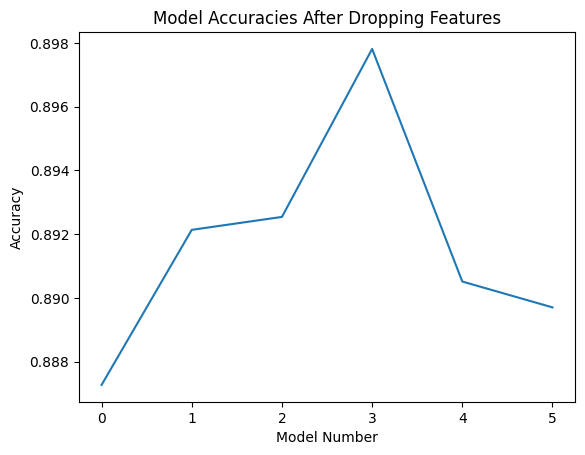

In [ ]:
plt.plot(dropAccuracies)
plt.xlabel('Model Number')
plt.ylabel('Accuracy')
plt.title('Model Accuracies After Dropping Features')
plt.show()

In [ ]:
X_train = X_train[['PageValues']]
X_val = X_val[['PageValues']]

model = Sequential()
model.add(Dense(8, input_dim=1, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('model_only_page_values.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, verbose=1, callbacks=[checkpoint])

_, accuracy = model.evaluate(X_val, y_val, verbose=1)

Epoch 1/100
309/309 [==============================] - ETA: 0s - loss: 0.5880 - accuracy: 0.8482
Epoch 1: val_loss improved from inf to 0.49061, saving model to model_only_page_values.h5
309/309 [==============================] - 2s 3ms/step - loss: 0.5880 - accuracy: 0.8482 - val_loss: 0.4906 - val_accuracy: 0.8451
Epoch 2/100
 84/309 [=======>......................] - ETA: 0s - loss: 0.4870 - accuracy: 0.8296

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


303/309 [============================>.] - ETA: 0s - loss: 0.4438 - accuracy: 0.8447
Epoch 2: val_loss improved from 0.49061 to 0.41200, saving model to model_only_page_values.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4418 - accuracy: 0.8458 - val_loss: 0.4120 - val_accuracy: 0.8459
Epoch 3/100
298/309 [===========================>..] - ETA: 0s - loss: 0.4016 - accuracy: 0.8466
Epoch 3: val_loss improved from 0.41200 to 0.38872, saving model to model_only_page_values.h5
309/309 [==============================] - 1s 2ms/step - loss: 0.4011 - accuracy: 0.8465 - val_loss: 0.3887 - val_accuracy: 0.8471
Epoch 4/100
291/309 [===========================>..] - ETA: 0s - loss: 0.3848 - accuracy: 0.8488
Epoch 4: val_loss improved from 0.38872 to 0.37116, saving model to model_only_page_values.h5
309/309 [==============================] - 1s 3ms/step - loss: 0.3832 - accuracy: 0.8498 - val_loss: 0.3712 - val_accuracy: 0.8524
Epoch 5/100
306/309 [=========================